## Prepare dataset

### Split the data into train and val sets

In [1]:
import os
import shutil
import random

# Define the paths
base_path = "datasets/v2_finetune_dataset/"
train_images_dir = os.path.join(base_path, "images/train")
val_images_dir = os.path.join(base_path, "images/val")
train_labels_dir = os.path.join(base_path, "labels/train")
val_labels_dir = os.path.join(base_path, "labels/val")

# Ensure the val directories exist
os.makedirs(val_images_dir, exist_ok=True)
os.makedirs(val_labels_dir, exist_ok=True)

# List all image files in the train directory
image_files = [f for f in os.listdir(train_images_dir) if f.endswith('.png')]

# Define the percentage of data to move to validation
val_percentage = 0.1
num_val_images = int(len(image_files) * val_percentage)

# Shuffle and select a subset for validation
random.shuffle(image_files)
val_images = image_files[:num_val_images]

# Move the selected images and their corresponding labels
for img_file in val_images:
    # Move image
    src_img_path = os.path.join(train_images_dir, img_file)
    dst_img_path = os.path.join(val_images_dir, img_file)
    shutil.move(src_img_path, dst_img_path)

    # Move corresponding label
    label_file = img_file.replace('.png', '.txt')
    src_label_path = os.path.join(train_labels_dir, label_file)
    dst_label_path = os.path.join(val_labels_dir, label_file)
    if os.path.exists(src_label_path):
        shutil.move(src_label_path, dst_label_path)

print("Data successfully transferred from train to val directories.")


Data successfully transferred from train to val directories.


### Augment the dataset with albumentations

In [3]:
import albumentations as A
import random
import cv2
import os
from albumentations.pytorch import ToTensorV2

# Define all possible augmentations
augmentation_choices = [
    # Spatial-level augmentations
    A.RandomRotate90(p=1),
    A.Flip(p=1),
    A.Transpose(),
    # A.OpticalDistortion(p=0.3),
    # A.GridDistortion(p=0.1),
    
    # Pixel-level augmentations
    A.GaussianBlur(p=0.1),
    A.MotionBlur(p=0.2),
    A.MedianBlur(blur_limit=3, p=0.1),
    A.Blur(blur_limit=3, p=0.1),
    A.CLAHE(clip_limit=2),
    A.RandomBrightnessContrast(),
    A.RandomGamma(p=0.1),
    A.HueSaturationValue(p=0.3),
    A.RGBShift(p=0.1),
    A.ChannelShuffle(p=0.1),
    A.ISONoise(p=0.1),
    A.ImageCompression(quality_lower=75, quality_upper=100, p=0.1)
]

# Define function to create a transformation pipeline with SomeOf
def get_random_transform():
    return A.Compose([
        A.SomeOf(augmentation_choices, n=6, replace=False)
    ], bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels']))

def load_bboxes_from_file(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()
    bboxes = []
    for line in lines:
        class_id, x_center, y_center, width, height = map(float, line.strip().split())
        bboxes.append([x_center, y_center, width, height, class_id])
    return bboxes

def save_bboxes_to_file(bboxes, file_path):
    with open(file_path, 'w') as file:
        for bbox in bboxes:
            class_id = int(bbox[4])
            x_center, y_center, width, height = bbox[:4]
            file.write(f"{class_id} {x_center} {y_center} {width} {height}\n")

def save_image(image, file_path):
    cv2.imwrite(file_path, image)

# Paths to train and val directories
train_img_dir = "/Users/sudhanshukumar/Documents/GitHub/multi_vehicle_count/datasets/v2_finetune_dataset/images/train"
val_img_dir = "/Users/sudhanshukumar/Documents/GitHub/multi_vehicle_count/datasets/v2_finetune_dataset/images/val"
train_lbl_dir = "/Users/sudhanshukumar/Documents/GitHub/multi_vehicle_count/datasets/v2_finetune_dataset/labels/train"
val_lbl_dir = "/Users/sudhanshukumar/Documents/GitHub/multi_vehicle_count/datasets/v2_finetune_dataset/labels/val"

# Augment images and save them
def augment_and_save_images(img_dir, lbl_dir):
    img_files = [f for f in os.listdir(img_dir) if f.endswith('.png')]
    img_files.sort()
    
    for img_file in img_files:
        img_path = os.path.join(img_dir, img_file)
        num = img_file.split('_')[-1].split('.')[0]
        bboxes_path = os.path.join(lbl_dir, img_file.replace('.png', '.txt'))

        if os.path.exists(bboxes_path):
            image = cv2.imread(img_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            bboxes = load_bboxes_from_file(bboxes_path)
            
            for i in range(3):  # Create three augmented copies
                transform = get_random_transform()
                
                transformed = transform(image=image, bboxes=bboxes, class_labels=[bbox[4] for bbox in bboxes])
                transformed_image = transformed['image']
                transformed_bboxes = transformed['bboxes']
                                
                new_img_file = img_path[:-4] + f"_aug_{i}.png"
                new_txt_file = bboxes_path[:-4] + f"_aug_{i}.txt"
                
                save_image(transformed_image, new_img_file)
                save_bboxes_to_file(transformed_bboxes, new_txt_file)
                print(f"Augmented and saved {new_img_file} and {new_txt_file}")

In [4]:
# Apply augmentation to train and val directories
augment_and_save_images(train_img_dir, train_lbl_dir)
augment_and_save_images(val_img_dir, val_lbl_dir)

Augmented and saved /Users/sudhanshukumar/Documents/GitHub/multi_vehicle_count/datasets/v2_finetune_dataset/images/train/output_0001_aug_0.png and /Users/sudhanshukumar/Documents/GitHub/multi_vehicle_count/datasets/v2_finetune_dataset/labels/train/output_0001_aug_0.txt
Augmented and saved /Users/sudhanshukumar/Documents/GitHub/multi_vehicle_count/datasets/v2_finetune_dataset/images/train/output_0001_aug_1.png and /Users/sudhanshukumar/Documents/GitHub/multi_vehicle_count/datasets/v2_finetune_dataset/labels/train/output_0001_aug_1.txt
Augmented and saved /Users/sudhanshukumar/Documents/GitHub/multi_vehicle_count/datasets/v2_finetune_dataset/images/train/output_0001_aug_2.png and /Users/sudhanshukumar/Documents/GitHub/multi_vehicle_count/datasets/v2_finetune_dataset/labels/train/output_0001_aug_2.txt
Augmented and saved /Users/sudhanshukumar/Documents/GitHub/multi_vehicle_count/datasets/v2_finetune_dataset/images/train/output_0002_aug_0.png and /Users/sudhanshukumar/Documents/GitHub/mult

In [6]:
img_path="datasets/finetune_dataset/images/train/output_0052.png"
bboxes_path="datasets/finetune_dataset/labels/train/output_0052.txt"

def load_bboxes_from_file(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()
    bboxes = []
    for line in lines:
        class_id, x_center, y_center, width, height = map(float, line.strip().split())
        bboxes.append([x_center, y_center, width, height, class_id])
    return bboxes

image = cv2.imread(img_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
bboxes = load_bboxes_from_file(bboxes_path)

for e in bboxes:
    print(e)
transform = get_random_transform()


transformed = transform(image=image, bboxes=bboxes, class_labels=[bbox[4] for bbox in bboxes])
transformed_image = transformed['image']
transformed_bboxes = transformed['bboxes']
                
# new_img_file = img_path[:-4] + f"_aug_{52}.png"
# new_txt_file = bboxes_path[:-4] + f"_aug_{52}.txt"

# save_image(transformed_image, new_img_file)
# save_bboxes_to_file(transformed_bboxes, new_txt_file)
# print(f"Augmented and saved {new_img_file} and {new_txt_file}")

[0.738366, 0.019521, 0.014972, 0.021177, 0.0]
[0.421102, 0.003549, 0.028611, 0.007099, 2.0]
[0.149069, 0.891953, 0.276435, 0.09125, 2.0]
[0.398708, 0.121438, 0.01312, 0.022552, 0.0]
[0.685653, 0.478823, 0.105065, 0.091615, 2.0]
[0.473866, 0.098482, 0.040565, 0.032786, 2.0]
[0.552051, 0.255164, 0.067824, 0.053057, 2.0]
[0.896093, 0.204482, 0.093685, 0.054682, 2.0]
[0.748551, 0.08818, 0.040843, 0.024422, 2.0]
[0.276745, 0.402974, 0.024269, 0.031333, 0.0]


### Test augmentation

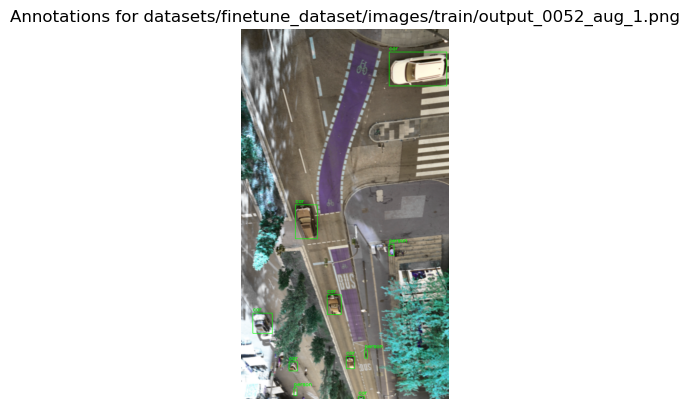

In [44]:
import os
import cv2
import matplotlib.pyplot as plt
import yaml
from collections import defaultdict

def load_class_names(yaml_file):
    with open(yaml_file, 'r') as file:
        data = yaml.safe_load(file)
        class_names = data['names']
    return class_names

def plot_annotations(annotation_file, class_names_file):
    # Create a dictionary to store annotations for each image
    annotations = defaultdict(list)
    
    # Extract the base name of the annotation file
    base_name = os.path.splitext(os.path.basename(annotation_file))[0]
    
    # Construct the corresponding image path
    image_path = os.path.join('datasets','finetune_dataset','images', 'train', f'{base_name}.png')
    
    # Read the annotation file
    with open(annotation_file, 'r') as file:
        lines = file.readlines()

    # Parse the annotations and store them in the dictionary
    for line in lines:
        parts = line.strip().split()
        class_index = parts[0]
        x_center, y_center, width, height = map(float, parts[1:])
        annotations[image_path].append((class_index, x_center, y_center, width, height))
    
    # Load class names
    class_names = load_class_names(class_names_file)
    
    # Load the image
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error: Could not read image {image_path}")
        return
    
    h, w = image.shape[:2]

    # Draw all the annotations on the image
    for class_index, x_center, y_center, width, height in annotations[image_path]:
        x1 = int((x_center - width / 2) * w)
        y1 = int((y_center - height / 2) * h)
        x2 = int((x_center + width / 2) * w)
        y2 = int((y_center + height / 2) * h)

        color = (0, 255, 0)  # Green color for bounding box
        class_name = class_names[int(class_index)]
        cv2.rectangle(image, (x1, y1), (x2, y2), color, 2)
        cv2.putText(image, class_name, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, color, 2)
    
    # Display the image with all annotations
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title(f'Annotations for {image_path}')
    plt.show()

# Call the function with your annotation file
plot_annotations('datasets/finetune_dataset/labels/train/output_0052_aug_1.txt', 'datasets/auto_annotated_dataset/data.yml')

### Roundabout dataset preparation - Stage 1

- Convert annotations to YOLO format
- Rename cycle to bicycle
- Save to disk

In [ ]:
import pandas as pd

# Load the CSV file
file_path = 'archive/data.csv'
df = pd.read_csv(file_path)

# Rename 'cycle' to 'bicycle'
df['class_name'] = df['class_name'].replace('cycle', 'bicycle')

# Drop rows with NaN values in 'class_name'
df = df.dropna(subset=['class_name'])

# Group annotations by image
grouped = df.groupby('image_name').agg(list).reset_index()

# Function to convert a single row to YOLO format
def convert_to_yolo(row, img_width, img_height):
    yolo_data = []
    class_mapping = {'person': 0, 'bicycle': 1, 'car': 2, 'motorcycle': 3, 'airplane': 4, 'bus': 5, 'train': 6, 'truck': 7}
    for i in range(len(row['x_min'])):
        class_id = class_mapping[row['class_name'][i]]
        x_center = (row['x_min'][i] + row['x_max'][i]) / 2 / img_width
        y_center = (row['y_min'][i] + row['y_max'][i]) / 2 / img_height
        width = (row['x_max'][i] - row['x_min'][i]) / img_width
        height = (row['y_max'][i] - row['y_min'][i]) / img_height
        yolo_data.append(f"{class_id} {x_center} {y_center} {width} {height}")
    return yolo_data

# For demonstration, assuming a common image size (replace with actual sizes)
img_width, img_height = 1920, 1080

# Convert grouped annotations to YOLO format
grouped['yolo_format'] = grouped.apply(lambda row: convert_to_yolo(row, img_width, img_height), axis=1)

# Function to save YOLO formatted data
def save_yolo_format(grouped_df, output_dir):
    for index, row in grouped_df.iterrows():
        img_name = row['image_name']
        yolo_annotations = row['yolo_format']
        txt_file = img_name.replace('.jpg', '.txt').replace('original/imgs/', output_dir)
        with open(txt_file, 'w') as f:
            for annotation in yolo_annotations:
                f.write(f"{annotation}\n")

# Save YOLO formatted annotations
output_dir = 'output/'
save_yolo_format(grouped, output_dir)

# Display some results
print(grouped.head())


#### Roundabout dataset preparation - Stage 2

The dataset is imbalanced. The number of images for each class is not equal. This can lead to a model that is biased towards the majority class. To address this, we will balance the dataset by selecting a subset of images that contain the prioritized classes.

**Strategy to Prioritize:**

- Calculate a priority score for each image based on the presence of bicycle, bus, and truck classes.
- Higher scores indicate images that contain more of the prioritized classes.
Select Images:

- Prioritize images based on their calculated priority scores.
- Choose images until reaching the desired number (1000 images in this case).

In [19]:
import os
import pandas as pd
import random
from collections import defaultdict

# Paths
annotation_dir = 'datasets/roundabout_dataset/annotations/'
image_dir = 'datasets/roundabout_dataset/imgs/'
output_dir = 'datasets/balanced_roundabout_dataset/annotations/'

# Class priorities
priority_classes = {1: 'bicycle', 5: 'bus', 7: 'truck'}
target_image_count = 2000

# Function to read annotations and determine the class presence
def read_annotations(annotation_file):
    with open(annotation_dir + annotation_file, 'r') as file:
        lines = file.readlines()
        classes = [int(line.split()[0]) for line in lines]
    return classes

# Function to analyze and prioritize images based on class presence
def analyze_and_prioritize_images():
    image_priorities = []
    for annotation_file in os.listdir(annotation_dir):
        if annotation_file.endswith('.txt'):
            classes = read_annotations(annotation_file)
            priority_score = sum(classes.count(cls) for cls in priority_classes)
            if priority_score > 0:
                image_priorities.append((priority_score, annotation_file))
    
    # Sort images by priority score in descending order
    image_priorities.sort(reverse=True, key=lambda x: x[0])
    return [img for _, img in image_priorities]

# Function to select images based on priority and balance the class distribution
def select_balanced_images(prioritized_images, target_count):
    selected_images = []
    class_distribution = defaultdict(int)
    for image in prioritized_images:
        if len(selected_images) >= target_count:
            break
        annotation_file = image
        classes = read_annotations(annotation_file)
        
        # Update the class distribution
        for cls in classes:
            class_distribution[cls] += 1
        
        # Add the image to the selected images list
        selected_images.append(annotation_file.replace('.txt', '.jpg'))
    
    return selected_images, class_distribution

# Function to save YOLO formatted data for selected images
def save_yolo_format(selected_images, output_dir):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    for img in selected_images:
        annotation_file = img.replace('.jpg', '.txt')
        with open(annotation_dir + annotation_file, 'r') as src:
            with open(output_dir + annotation_file, 'w') as dst:
                dst.writelines(src.readlines())

# Analyze and prioritize images
prioritized_images = analyze_and_prioritize_images()

# Select balanced images
selected_images, class_distribution = select_balanced_images(prioritized_images, target_image_count)

# Output the class distribution
print("Class Distribution:", class_distribution)

# Save selected annotations
save_yolo_format(selected_images, output_dir)

print(f"Selected {len(selected_images)} images")
print("Example selected images:", selected_images[:5])


Class Distribution: defaultdict(<class 'int'>, {2: 37959, 1: 3385, 7: 636, 5: 419})
Selected 2000 images
Example selected images: ['00001_frame001291_original.jpg', '00001_frame001296_original.jpg', '00001_frame001284_original.jpg', '00044_frame000039_original.jpg', '00001_frame001285_original.jpg']


#### Check the class distribution after balancing

Desc: This script goes through all the classes in annotations files and counts the number of classes.

In [26]:
import os
from collections import Counter

# Define the path to the directory containing the annotation files

# annotation_dir = 'datasets/balanced_roundabout_dataset/annotations/'
annotation_dir= 'datasets/v3_finetune_dataset/labels/train/'

# Initialize a counter to store the class distribution
class_counter = Counter()

# Traverse through all the annotation files in the directory
for annotation_file in os.listdir(annotation_dir):
    if annotation_file.endswith('.txt'):
        with open(os.path.join(annotation_dir, annotation_file), 'r') as file:
            for line in file:
                # Split the line to get the class_id (first element)
                class_id = line.split()[0]
                # Increment the counter for the class_id
                class_counter[class_id] += 1

# Print the class distribution
print("Class Distribution:")
for class_id, count in class_counter.items():
    print(f"Class {class_id}: {count} instances")


Class Distribution:
Class 2: 8060 instances
Class 1: 767 instances
Class 0: 400 instances
Class 9: 140 instances
Class 3: 40 instances
Class 7: 235 instances
Class 5: 94 instances


#### Copy the corresponding images to the images dir.

Use the names from the annotations and copy the images of the same name

In [ ]:
import os
import shutil

# Paths
annotations_dir = 'datasets/balanced_roundabout_dataset/annotations/'
source_imgs_dir = 'datasets/roundabout_dataset/imgs/'
target_imgs_dir = 'datasets/balanced_roundabout_dataset/images/'

# Ensure the target directory exists
os.makedirs(target_imgs_dir, exist_ok=True)

# Get list of selected annotation files
selected_annotations = [f for f in os.listdir(annotations_dir) if f.endswith('.txt')]

# Extract image filenames from annotation filenames
selected_images = [os.path.splitext(annotation)[0] + '.jpg' for annotation in selected_annotations]

# Copy images from source to target directory
for image in selected_images:
    source_path = os.path.join(source_imgs_dir, image)
    target_path = os.path.join(target_imgs_dir, image)
    shutil.copy(source_path, target_path)
    print(f"Copied {image} to {target_path}")

print("Image copying completed.")


#### Combine it with the original dataset and split it into train and val sets.

Combine the roundabout dataset with the original reeperbahn augmented dataset and split it into train and val sets.

In [ ]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Paths
annotations_dir = 'datasets/balanced_roundabout_dataset/annotations/'
images_dir = 'datasets/balanced_roundabout_dataset/images/'
output_base_dir = 'datasets/v3_finetune_dataset/'

# Ensure output directories exist
train_images_dir = os.path.join(output_base_dir, 'images/train/')
val_images_dir = os.path.join(output_base_dir, 'images/val/')
train_labels_dir = os.path.join(output_base_dir, 'labels/train/')
val_labels_dir = os.path.join(output_base_dir, 'labels/val/')

os.makedirs(train_images_dir, exist_ok=True)
os.makedirs(val_images_dir, exist_ok=True)
os.makedirs(train_labels_dir, exist_ok=True)
os.makedirs(val_labels_dir, exist_ok=True)

# Get list of images and corresponding annotations
image_files = [f for f in os.listdir(images_dir) if f.endswith('.jpg')]
annotation_files = [f for f in os.listdir(annotations_dir) if f.endswith('.txt')]

# Sort files to ensure matching order
image_files.sort()
annotation_files.sort()

# Split data into train and validation sets
train_images, val_images, train_annotations, val_annotations = train_test_split(
    image_files, annotation_files, test_size=0.2, random_state=42)

# Function to rename and copy files
def rename_and_copy(files, src_dir, dst_dir, start_number, ext):
    for i, file in enumerate(files, start=start_number):
        new_name = f"output_{i:04d}.{ext}"
        src_path = os.path.join(src_dir, file)
        dst_path = os.path.join(dst_dir, new_name)
        shutil.copy(src_path, dst_path)
        print(f"Copied and renamed {src_path} to {dst_path}")

# Rename and copy train images and annotations
rename_and_copy(train_images, images_dir, train_images_dir, 123, 'jpg')
rename_and_copy(train_annotations, annotations_dir, train_labels_dir, 123, 'txt')

# Rename and copy val images and annotations
rename_and_copy(val_images, images_dir, val_images_dir, 123 + len(train_images), 'jpg')
rename_and_copy(val_annotations, annotations_dir, val_labels_dir, 123 + len(train_annotations), 'txt')

print("Renaming and splitting completed.")
